In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from matplotlib.ticker import FuncFormatter

In [3]:
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns', None)

In [4]:
df_tmdb = pd.read_csv('../data/raw/TMDB_movie_dataset_v11.csv')
df_cpi = pd.read_csv('../data/raw/cpi_data.csv')

In [5]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    1348 non-null   object 
 1   cpi     1348 non-null   float64
dtypes: float64(1), object(1)
memory usage: 21.2+ KB


- Пропуски отсутствуют, однако для "year" стоит сразу поменять тип данных. 
- Имя столбца `year` меняем на  `cpi_date`

In [6]:
df_cpi.rename(columns={'year': 'cpi_date'}, inplace=True)
df_cpi['cpi_date'] = pd.to_datetime(df_cpi['cpi_date'], errors='coerce')
df_cpi.head(3)

,cpi_date,cpi
0,1913-01-01,9.80
1,1913-02-01,9.80
2,1913-03-01,9.80


In [7]:
latest_cpi = df_cpi.loc[df_cpi['cpi_date'].idxmax(), 'cpi']
df_cpi['latest_cpi'] = latest_cpi
df_cpi.head()

,cpi_date,cpi,latest_cpi
0,1913-01-01,9.80,320.80
1,1913-02-01,9.80,320.80
2,1913-03-01,9.80,320.80
3,1913-04-01,9.80,320.80
4,1913-05-01,9.70,320.80


- Оставляем нужные для проекта столбцы в df_tmdb

In [8]:
columns_to_keep = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries"   
]

In [9]:
df_tmdb = df_tmdb[columns_to_keep]

In [10]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231678 entries, 0 to 1231677
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1231678 non-null  int64  
 1   title                 1231665 non-null  object 
 2   original_title        1231665 non-null  object 
 3   original_language     1231678 non-null  object 
 4   release_date          1002807 non-null  object 
 5   genres                719317 non-null   object 
 6   budget                1231678 non-null  int64  
 7   revenue               1231678 non-null  int64  
 8   vote_average          1231678 non-null  float64
 9   production_countries  665596 non-null   object 
dtypes: float64(1), int64(3), object(6)
memory usage: 94.0+ MB


In [11]:
old_rows = df_tmdb.shape[0]
old_rows

1231678

Датасет содержит информацию о 1231678 фильмах, собранную с платформы TMDB

- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `production_countries` - список стран, учавствовавших в производстве фильма

### Смена типов данных

In [12]:
df_tmdb.dtypes

id                        int64
title                    object
original_title           object
original_language        object
release_date             object
genres                   object
budget                    int64
revenue                   int64
vote_average            float64
production_countries     object
dtype: object

Типы данных корректны, за исключением `release_date`, который содержит информацию о дате релиза фильма

In [13]:
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')
df_tmdb['release_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1231678 entries, 0 to 1231677
Series name: release_date
Non-Null Count    Dtype         
--------------    -----         
1002807 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 9.4 MB


- Преобразуем содержимое строковых данных к нижнему регистру, чтобы избежать возможных дубликатов

In [14]:
def lower_column(df, columns_to_lower):
    '''Принимает датафрейм и список столбцов,
    затем приводит содержимое столбцов
    к нижнему регистру'''

    for col in columns_to_lower:
        df[col] = df[col].str.lower()

In [15]:
str_column = ['title', 
              'original_title', 
              'original_language', 
              'genres', 
              'production_countries']

In [16]:
lower_column(df_tmdb, str_column)
df_tmdb[str_column].head(3)

,title,original_title,original_language,genres,production_countries
0,inception,inception,en,"action, science fiction, adventure","united kingdom, united states of america"
1,interstellar,interstellar,en,"adventure, drama, science fiction","united kingdom, united states of america"
2,the dark knight,the dark knight,en,"drama, action, crime, thriller","united kingdom, united states of america"


### Объединяем датафреймы

- Объединяем df_tmdb и df_cpi по дате начала месяца. Для этого добавим новый столбец в df_tmdb, который приведет release_date к началу месяца

In [17]:
df_tmdb['release_month'] = (df_tmdb['release_date']
                            .dt.to_period('M')
                            .dt.to_timestamp()
                            )

In [18]:
df_merged = df_tmdb.merge(df_cpi,
                          left_on='release_month',
                          right_on='cpi_date',
                          how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231678 entries, 0 to 1231677
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1231678 non-null  int64         
 1   title                 1231665 non-null  object        
 2   original_title        1231665 non-null  object        
 3   original_language     1231678 non-null  object        
 4   release_date          1002807 non-null  datetime64[ns]
 5   genres                719317 non-null   object        
 6   budget                1231678 non-null  int64         
 7   revenue               1231678 non-null  int64         
 8   vote_average          1231678 non-null  float64       
 9   production_countries  665596 non-null   object        
 10  release_month         1002807 non-null  datetime64[ns]
 11  cpi_date              990349 non-null   datetime64[ns]
 12  cpi                   990349 non-null   fl

### Проверка на дубликаты

In [19]:
df_merged.duplicated().sum()

np.int64(472)

- Найдено 472 полных дубликатов строк, удаляем их

In [20]:
df_merged = df_merged.drop_duplicates().reset_index(drop=True)
df_merged.duplicated().sum()

np.int64(0)

- Проверим, есть ли дубликаты по столбцам с информацией об оригинальном названии фильма и датой релиза

In [21]:
df_merged[['original_title', 'release_date']].duplicated().sum()

np.int64(19018)

- Фильмы с одинаковым оригинальным названием и одинаковой датой релиза могут указывать на дубликаты - удаляем их

In [22]:
df_merged = df_merged.drop_duplicates(subset=['original_title', 'release_date'])
df_merged = df_merged.reset_index(drop=True)

In [23]:
df_merged['original_title'].value_counts()

original_title
home                           94
untitled                       84
alone                          72
carmen                         63
limbo                          56
                               ..
stryker's best powerful sex     1
future story                    1
big naturals 67                 1
true darkness: keep moving      1
my grandparents                 1
Name: count, Length: 1076915, dtype: int64

- `untitled` - указывает на отсутствие информации об оригинальном названии фильма

Одинаковые названия фильмов действительно могут встречаться - главное, чтобы даты релизов не совпадали

- Теперь проверим дубликаты, связанные с англоязычным названием и датой релиза

In [24]:
df_merged[['title', 'release_date']].duplicated().sum()

np.int64(1848)

Найдено 1848 дубликатов по столбцам с англоязычным названием фильма и датой релиза

In [25]:
df_merged[df_merged.duplicated(subset=['title', 'release_date'], keep=False)][['title', 'release_date']].value_counts()

title                 release_date
chosen 2              2020-01-13      3
fatal love            1993-01-01      3
8 seconds             1994-02-25      2
resurrection of love  1973-01-01      2
run!                  2013-10-23      2
                                     ..
gray                  2016-02-04      2
golmorich             2021-02-14      2
god's gift            1998-01-01      2
girls                 2014-07-30      2
zhanxiou village      2007-05-20      2
Name: count, Length: 345, dtype: int64

Проверим фильм  `chosen 2`, чтобы понять, стоит ли нам считать совпадение по дате релиза и англоязычному названию - дубликатами

In [26]:
df_merged[df_merged['title'] == 'chosen 2']

,id,title,original_title,original_language,release_date,genres,budget,revenue,vote_average,production_countries,release_month,cpi_date,cpi,latest_cpi
500224,1160180,chosen 2,杀无赦2：ⅰ救赎,en,2020-01-13,NaN,0,0,0.00,NaN,2020-01-01,2020-01-01,257.97,320.80
500227,1160183,chosen 2,杀无赦2：ⅱ同盟,en,2020-01-13,NaN,0,0,0.00,NaN,2020-01-01,2020-01-01,257.97,320.80
500228,1160184,chosen 2,杀无赦2：ⅲ重生,en,2020-01-13,NaN,0,0,0.00,NaN,2020-01-01,2020-01-01,257.97,320.80


In [27]:
df_merged[df_merged['title'] == 'zhanxiou village']

,id,title,original_title,original_language,release_date,genres,budget,revenue,vote_average,production_countries,release_month,cpi_date,cpi,latest_cpi
536008,1405386,zhanxiou village,朱辛庄,zh,2007-05-20,NaN,0,0,0.00,china,2007-05-01,2007-05-01,207.95,320.80
597691,1469333,zhanxiou village,zhanxiou village,en,2007-05-20,NaN,0,0,0.00,NaN,2007-05-01,2007-05-01,207.95,320.80
658577,1264836,zhanxiou village,zhanxiou village,fr,2007-05-15,NaN,0,0,0.00,NaN,2007-05-01,2007-05-01,207.95,320.80


- Оригинальные названия разные, судя по всему, это могут быть разные части одного проекта, релизнутые в один день. 

Совпадения по дате релиза и англоязычному названию НЕ указывают на дубликаты

In [28]:
new_rows = df_merged.shape[0]
print(f'''Было удалено {old_rows - new_rows} строк.
Мы лишились {round((old_rows - new_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 19490 строк.
Мы лишились 1.58% данных


### Анализ пропусков

In [29]:
df_merged.isnull().sum().sort_values(ascending=False)

production_countries    549731
genres                  498121
cpi_date                223903
cpi                     223903
latest_cpi              223903
release_date            211474
release_month           211474
title                        5
original_title               5
id                           0
original_language            0
budget                       0
revenue                      0
vote_average                 0
dtype: int64

In [30]:
(df_merged.isnull().mean() * 100).sort_values(ascending=False).round(2)

production_countries   45.35
genres                 41.09
cpi_date               18.47
cpi                    18.47
latest_cpi             18.47
release_date           17.45
release_month          17.45
title                   0.00
original_title          0.00
id                      0.00
original_language       0.00
budget                  0.00
revenue                 0.00
vote_average            0.00
dtype: float64

У нас отсутствует свыше 40% информации по странам производства и жанрам. Также есть пропуски в 17% информации о дате релиза, 18% пропусков по информации о cpi.


- Данные CPI у нас есть с 1913 года, поэтому исключим фильмы, для которых не определено CPI

In [31]:
df_merged = df_merged[df_merged['cpi'].notna()].reset_index(drop=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988285 entries, 0 to 988284
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    988285 non-null  int64         
 1   title                 988281 non-null  object        
 2   original_title        988281 non-null  object        
 3   original_language     988285 non-null  object        
 4   release_date          988285 non-null  datetime64[ns]
 5   genres                662297 non-null  object        
 6   budget                988285 non-null  int64         
 7   revenue               988285 non-null  int64         
 8   vote_average          988285 non-null  float64       
 9   production_countries  627414 non-null  object        
 10  release_month         988285 non-null  datetime64[ns]
 11  cpi_date              988285 non-null  datetime64[ns]
 12  cpi                   988285 non-null  float64       
 13 

Кажется, что в столбце бюджета и дохода пропусков нет, однако там пропущенные значения могут обозначаться как 0

In [32]:
df_merged['budget'].value_counts()

budget
0         938854
100         1540
1000        1375
10000       1297
500         1192
           ...  
32125          1
647000         1
151105         1
266103         1
61267          1
Name: count, Length: 5296, dtype: int64

### Анализ REVENUE

In [33]:
def millions(x, pos):
    '''Функция используется с FuncFormat 
    для форматирования значения x в миллионах 
    с округлением до одного знака после запятой'''
    return f'{x * 1e-6:.1f}'

In [34]:
df_merged['revenue'].value_counts()

revenue
0           968943
100            350
1              312
10             160
1000           160
             ...  
53977250         1
1749201          1
32704700         1
53672080         1
55390            1
Name: count, Length: 14109, dtype: int64

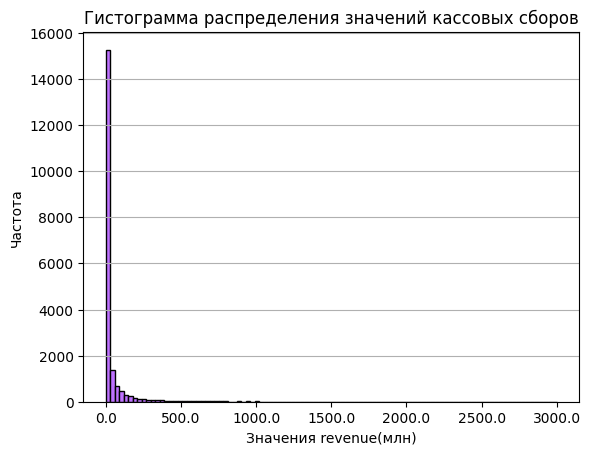

In [35]:
plt.hist(df_merged[df_merged['revenue'] > 0]['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Значения revenue(млн)')
plt.ylabel('Частота')

plt.show()

Большая часть данных хранит в себе значение "0" в столбце кассовых сборов (доходов). 

In [36]:
df_merged['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,988285.00,767637.57,18561457.73,-12.00,0.00,0.00,0.00,3000000000.00


Высокое значение стандартного отклонения указывает на большой разброс данных - есть выбросы. Учитывая, что 75-й квантиль равен 0, можно сделать вывод - большинство данных не имеют информации о кассовых сборах  

In [37]:
df_merged[df_merged['revenue'] > 0]['revenue'].count()

np.int64(19341)

Ненулевых значений кассовых сборов у нас 21713

- Объявим переменную, которая будет хранить булевую маску со значениями, где кассовые сборы были больше 0

In [38]:
filter_not_zero = df_merged['revenue'] > 0
filter_not_zero.head(3)

0    True
1    True
2    True
Name: revenue, dtype: bool

- Объявим переменные, которые будут хранить значения 30-го и 99-го квантиля

In [39]:
quantile_min = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.3)
quantile_min.round(2)

np.float64(175706.0)

In [40]:
quantile_max = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.99)
quantile_max.round(2)

np.float64(626177032.6)

Отфильтруем наш датасет по значениям от 30-го квантиля до 99-го, чтобы избавиться от аномальных значений 

In [41]:
df_filtered = df_merged[(df_merged['revenue'] > quantile_min) & (df_merged['revenue'] < quantile_max)]
df_filtered = df_filtered.copy()
df_filtered.head(3)

,id,title,original_title,original_language,release_date,genres,budget,revenue,vote_average,production_countries,release_month,cpi_date,cpi,latest_cpi
7,550,fight club,fight club,en,1999-10-15,drama,63000000,100853753,8.44,united states of america,1999-10-01,1999-10-01,168.20,320.80
9,680,pulp fiction,pulp fiction,en,1994-09-10,"thriller, crime",8500000,213900000,8.49,united states of america,1994-09-01,1994-09-01,149.40,320.80
12,1726,iron man,iron man,en,2008-04-30,"action, science fiction, adventure",140000000,585174222,7.64,united states of america,2008-04-01,2008-04-01,214.82,320.80


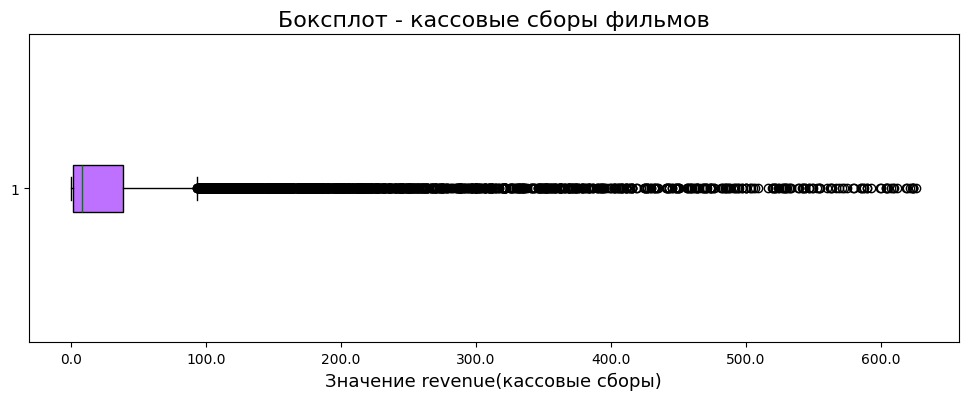

In [42]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['revenue'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.title('Боксплот - кассовые сборы фильмов', fontsize=16)
plt.xlabel('Значение revenue(кассовые сборы)', fontsize=13)

plt.show()

На боксплоте видно, что все аномальные значения находятся справа - их довольно много. 
Это бестселлеры, которые действительно получили огромные кассовые сборы

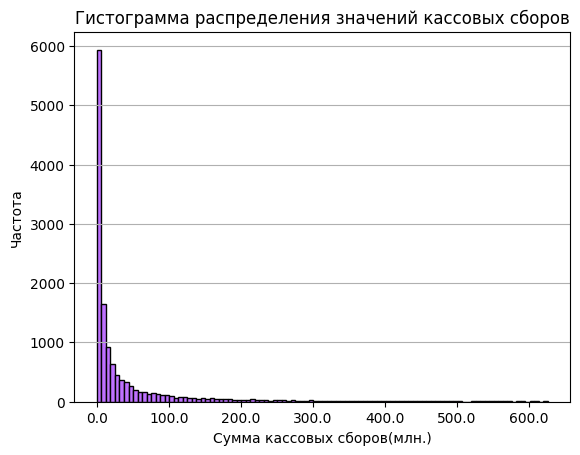

In [43]:
plt.hist(df_filtered['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Сумма кассовых сборов(млн.)')
plt.ylabel('Частота')

plt.show()

In [44]:
df_filtered['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,13344.00,42509569.26,84771413.51,175742.00,1812957.75,8786052.50,38600000.00,626137675.00


- После фильтрации по процентилям у нас осталось 14981 данных. При этом заметно сильное смещение гистограммы в правую сторону, что говорит о наличии очень больших значений. Вероятно, это данные о бестселлерах, которые действительно могли принести очень большую прибыль 

### Анализ BUDGET

In [45]:
df_filtered[df_filtered['budget'] == 0].shape[0]

4345

5019 количество фильмов не содержат информации о бюджете 

In [46]:
df_filtered[df_filtered['budget'] > 0].shape[0]

8999

9962 фильмов содержат информацию о бюджете

In [47]:
df_filtered['budget'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
budget,13344.00,15812343.30,30117546.40,0.00,0.00,3000000.00,19000000.00,645654654.00


Мы видим большое стандратное отклонение, которое указывает на выбросы. У 25% фильмов отсутсвует информация о бюджете

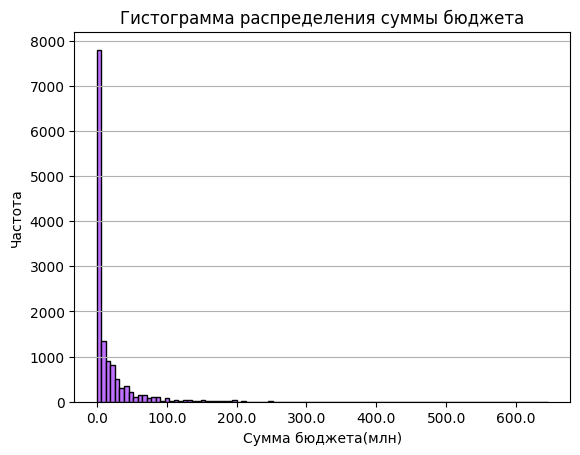

In [48]:
plt.hist(df_filtered['budget'],
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения суммы бюджета')
plt.xlabel('Сумма бюджета(млн)')
plt.ylabel('Частота')


plt.show()

- Распределение сильно смещено вправо: встречаются редкие, но очень крупные бюджеты
- Около 25% фильмов имеют нулевой бюджет, это значит, что данные либо отсутствуют - это типичная ситуация для фильмов, финансируемых: государственными субсидиями, международными фондами, кинокомиссиями.

По этой причине нулевые значения мы оставляем 

### Анализ PRODUCTION_COUNTRIES

In [49]:
df_filtered['production_countries'].value_counts()

production_countries
united states of america                                  5846
india                                                      700
united kingdom, united states of america                   418
japan                                                      412
united kingdom                                             328
                                                          ... 
argentina, france                                            1
spain, united kingdom, italy, united states of america       1
belgium, france, germany, israel, luxembourg, poland         1
united states of america, india, canada                      1
kazakhstan                                                   1
Name: count, Length: 1129, dtype: int64

В данных по странам производства присутствуют строки с несколькими странами. Будем брать первую страну из списка, так как чаще всего именно она отражает основную страну производства. Такой подход соответствует распространённой практике в исследовательских работах и научных публикациях, где при множественном указании стран приоритет отдаётся первой по порядку как представителю основного продюсера проекта.

In [50]:
df_filtered['main_country'] = (
                                df_filtered['production_countries']
                               .str.split(',', expand=True)[0]
                               )

In [51]:
df_filtered.head(3)

,id,title,original_title,original_language,release_date,genres,budget,revenue,vote_average,production_countries,release_month,cpi_date,cpi,latest_cpi,main_country
7,550,fight club,fight club,en,1999-10-15,drama,63000000,100853753,8.44,united states of america,1999-10-01,1999-10-01,168.20,320.80,united states of america
9,680,pulp fiction,pulp fiction,en,1994-09-10,"thriller, crime",8500000,213900000,8.49,united states of america,1994-09-01,1994-09-01,149.40,320.80,united states of america
12,1726,iron man,iron man,en,2008-04-30,"action, science fiction, adventure",140000000,585174222,7.64,united states of america,2008-04-01,2008-04-01,214.82,320.80,united states of america


In [52]:
df_filtered['main_country'].value_counts()

main_country
united states of america    6038
united kingdom               810
india                        742
france                       706
canada                       496
                            ... 
senegal                        1
namibia                        1
macedonia                      1
bosnia and herzegovina         1
kazakhstan                     1
Name: count, Length: 109, dtype: int64

In [53]:
df_country = df_filtered['main_country'].value_counts(ascending=True).reset_index()
df_country.head(2)

,main_country,count
0,kazakhstan,1
1,lebanon,1


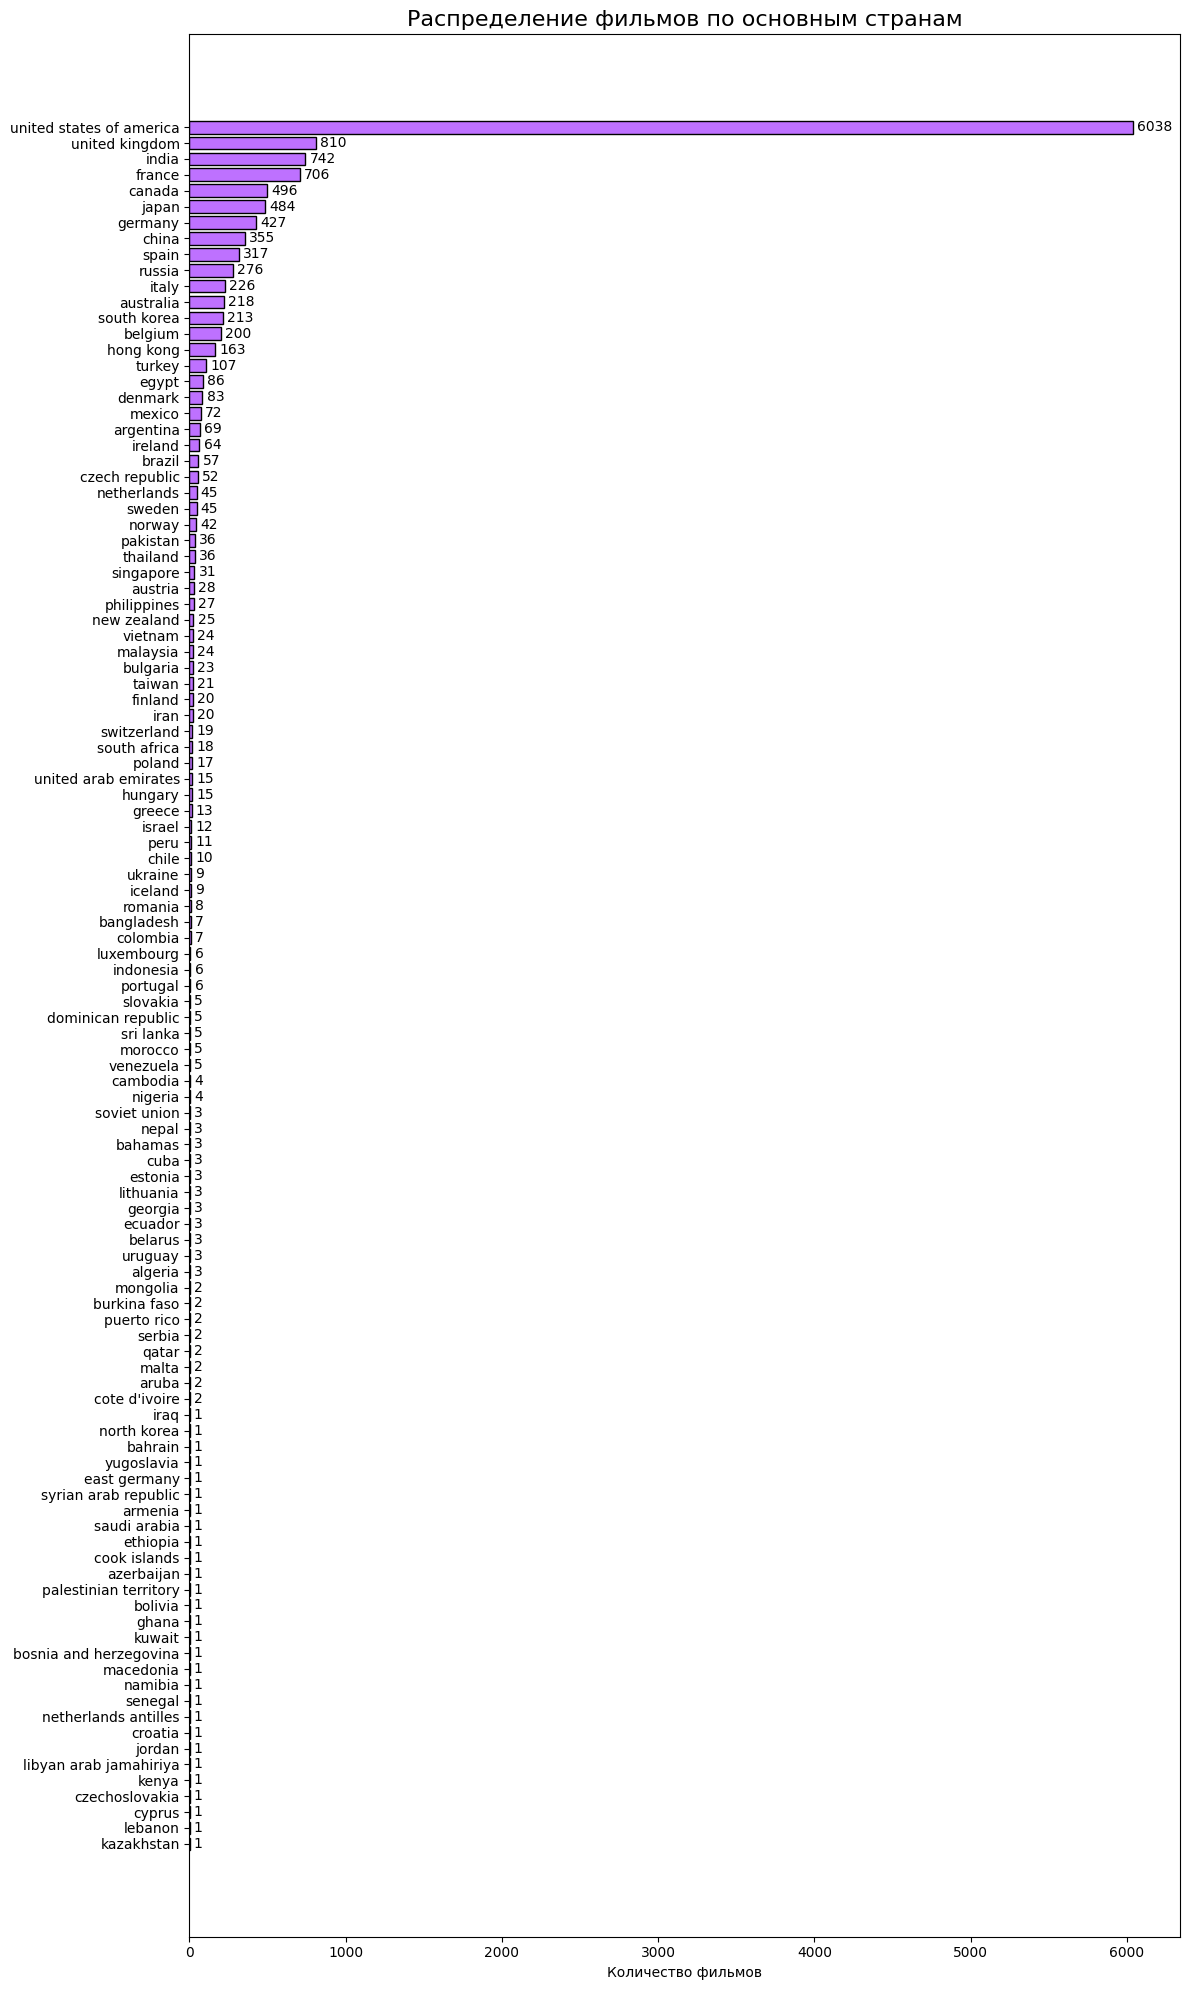

In [54]:
plt.figure(figsize=(12, 20))

bars = plt.barh(
    y=df_country['main_country'],
    width=df_country['count'],
    color='#be71ff',
    edgecolor='black'
)

plt.gca().bar_label(bars, fmt='%.0f', padding=3)

plt.xlabel('Количество фильмов')
plt.title('Распределение фильмов по основным странам', fontsize=16)
plt.tight_layout()
plt.show()

### Анализ VOTE_AVERTAGE

In [55]:
df_filtered['vote_average'].value_counts()

vote_average
0.00    372
6.00    223
7.00    149
6.50    139
6.20    129
       ... 
7.21      1
8.34      1
8.10      1
4.40      1
8.44      1
Name: count, Length: 3261, dtype: int64

У нас действительно могут встречаться фильмы без оценок пользователей, так что тут значение 0 не критично

In [56]:
df_filtered['vote_average'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
vote_average,13344.00,6.19,1.46,0.00,5.75,6.40,7.00,10.00


Стандартное отклонение не критичное, а значит вариативность умеренная

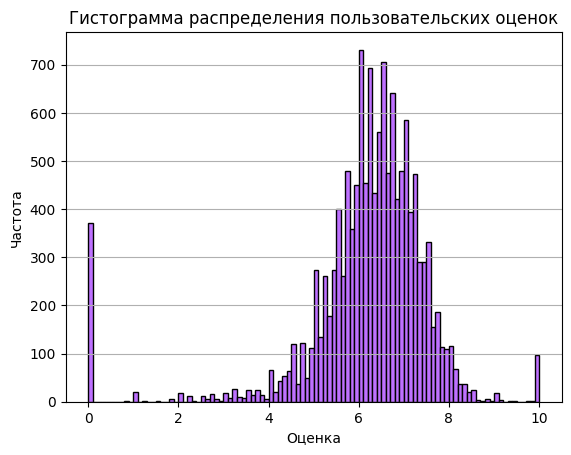

In [57]:
plt.hist(df_filtered['vote_average'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.grid(axis='y')

plt.title('Гистограмма распределения пользовательских оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.show()

- Распределение с левосторонней ассиметрией
- Вытянутый левый хвост обусловлен наличием свыше 900 нулевых оценок

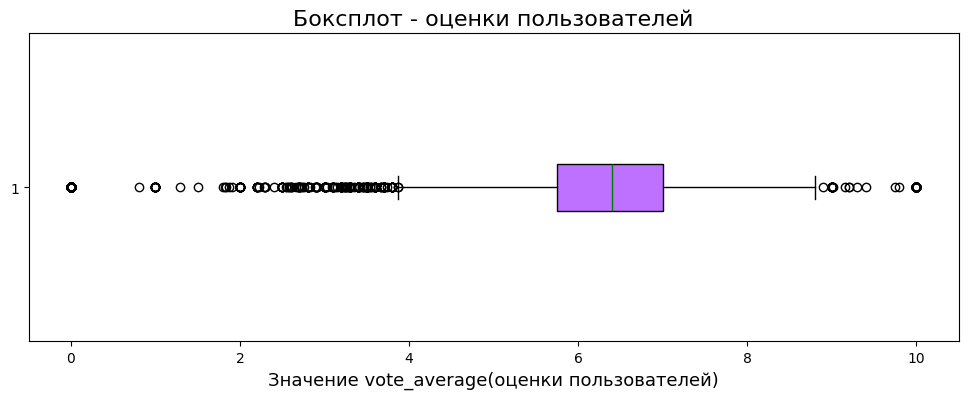

In [58]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['vote_average'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.title('Боксплот - оценки пользователей', fontsize=16)
plt.xlabel('Значение vote_average(оценки пользователей)', fontsize=13)

plt.show()

- Основная часть оценок приходится на значения ~5.6-6.97. Слева у нас наблюдается много выбросов, справа выбросы тоже есть, но их меньше. 
- Низкая оценка, как и ее отсутствие, может быть связана с малой популярностью фильма, возможно даже полным отсутствием популярности. 
- Высокая оценка может быть связана с большой положительной популярностью фильма, а также присутствует и такой вариант, что фильм не особо известен, у него не так много оценок - но все высокие. Тогда наша средняя оценка сильно завышается

### Уникальные значения

- Уникальные значения в жанрах

In [59]:
df_filtered['genres'].value_counts()

genres
drama                                                            983
comedy                                                           910
drama, romance                                                   485
comedy, drama                                                    424
comedy, romance                                                  408
                                                                ... 
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
drama, crime, thriller, comedy                                     1
drama, family, documentary                                         1
Name: count, Length: 2325, dtype: int64

- У нас встречаются строки с перечислением нескольких жанров

In [60]:
df_filtered['genres'].isnull().sum()

np.int64(89)

У 426 фильмов отсутствует информация о жанрах, можно заменить на "undefined"

In [61]:
df_filtered['genres'] = df_filtered['genres'].fillna('undefined')

In [62]:
df_filtered['genres'].value_counts()

genres
drama                                                            983
comedy                                                           910
drama, romance                                                   485
comedy, drama                                                    424
comedy, romance                                                  408
                                                                ... 
mystery, drama, thriller, comedy                                   1
family, comedy, adventure, animation, fantasy                      1
adventure, action, fantasy, war, history                           1
action, adventure, comedy, fantasy, science fiction, thriller      1
drama, family, documentary                                         1
Name: count, Length: 2326, dtype: int64

Изучим уникальные данные по столбцу с original_language

In [63]:
df_tmdb['original_language'].value_counts()

original_language
en    668885
fr     71863
es     63186
de     57417
ja     53891
       ...  
an         1
rn         1
ts         1
kg         1
ii         1
Name: count, Length: 176, dtype: int64

- Пропуски отсутствуют - данные выглядят полными

### Учет инфляции 

Добавим два столбца:
- `current_budget` - бюджет с учетом инфляции
- `current_revenue` - кассовые сборы с учетом инфляции

In [64]:
df_filtered['current_budget'] = (
    df_filtered['budget'] * (df_filtered['latest_cpi'] / df_filtered['cpi'])
)
df_filtered[['budget', 'current_budget']].head(3)

,budget,current_budget
7,63000000,120155083.23
9,8500000,18251388.89
12,140000000,209061878.85


In [65]:
df_filtered['current_revenue'] = (
    df_filtered['revenue'] * (df_filtered['latest_cpi'] / df_filtered['cpi'])
)
df_filtered[['revenue', 'current_revenue']].head(3)

,revenue,current_revenue
7,100853753,192350652.16
9,213900000,459290833.33
12,585174222,873840159.32


### Итог 

In [66]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13344 entries, 7 to 986590
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13344 non-null  int64         
 1   title                 13344 non-null  object        
 2   original_title        13344 non-null  object        
 3   original_language     13344 non-null  object        
 4   release_date          13344 non-null  datetime64[ns]
 5   genres                13344 non-null  object        
 6   budget                13344 non-null  int64         
 7   revenue               13344 non-null  int64         
 8   vote_average          13344 non-null  float64       
 9   production_countries  13006 non-null  object        
 10  release_month         13344 non-null  datetime64[ns]
 11  cpi_date              13344 non-null  datetime64[ns]
 12  cpi                   13344 non-null  float64       
 13  latest_cpi          

In [67]:
columns_to_keep = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "main_country",
    "cpi",
    "latest_cpi", 
    "current_budget",
    "current_revenue"  
]

In [68]:
df_filtered = df_filtered[columns_to_keep].copy()
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13344 entries, 7 to 986590
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 13344 non-null  int64         
 1   title              13344 non-null  object        
 2   original_title     13344 non-null  object        
 3   original_language  13344 non-null  object        
 4   release_date       13344 non-null  datetime64[ns]
 5   genres             13344 non-null  object        
 6   budget             13344 non-null  int64         
 7   revenue            13344 non-null  int64         
 8   vote_average       13344 non-null  float64       
 9   main_country       13006 non-null  object        
 10  cpi                13344 non-null  float64       
 11  latest_cpi         13344 non-null  float64       
 12  current_budget     13344 non-null  float64       
 13  current_revenue    13344 non-null  float64       
dtypes: datetim

Наш отфильтрованный и предобработанный датасет состоит из **13344** строк и 13 столбцов

- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `main_country` - главная страна, учавствовавшая в производстве фильма
- `cpi` - cpi на дату выхода фильма
- `latest_cpi` - актуальный cpi
- `current_budget` - сумма бюджета с учетом инфляции
- `current_revenue` - сумма кассовых сборов с учетом инфляции

 ## Графики (примеры + могут дополняться)

**scatter plot - corrent_revenue vs vote_average**


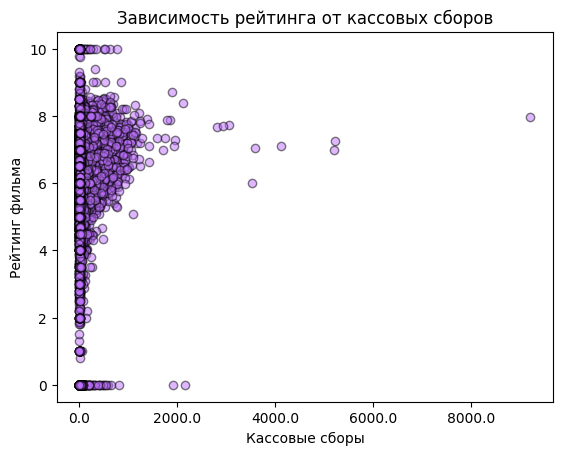

In [69]:
plt.scatter(
    df_filtered['current_revenue'],
    df_filtered['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Уберем выбросы

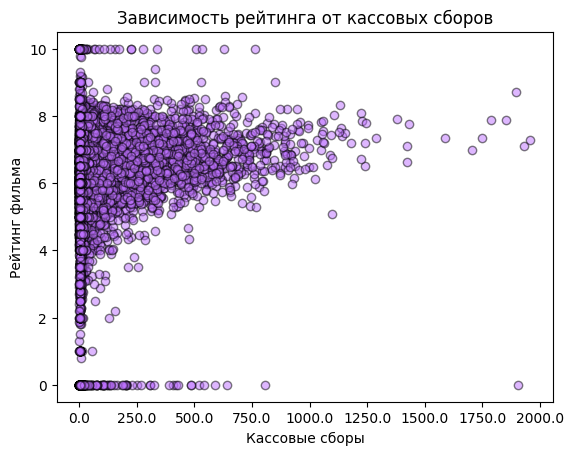

In [70]:
plt.scatter(
    df_filtered[df_filtered['current_revenue'] < 2000000000]['current_revenue'],
    df_filtered[df_filtered['current_revenue'] < 2000000000]['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Большинство фильмов имеют относительно низкие сборы, вне зависимости от рейтинга.
- Высокие сборы - чаще высокие рейтинги. На графике видно, что с увеличением значения кассовых сборов, фильмов становится меньше, однако рейтинг у них держится в районе 6-9.

Посчитаем коэффициент корреляции Пирсона. 

- менее 0.3 - слабая
- от 0.3 до 0.5 - умеренная
- от 0.5 до 0.7 - заметная
- от 07 до 0.9 - высокая

In [71]:
subset = df_filtered[df_filtered['current_revenue'] < 2_000_000_000]
subset = subset[['current_revenue', 'vote_average']].dropna()
correlation = subset['current_revenue'].corr(subset['vote_average'])

print(f'Коэффициент корреляции Пирсона: {correlation:.3f}')

Коэффициент корреляции Пирсона: 0.153


- Прослеживается слабая положительная корреляция

**Линейный график - кол-во фильмов**

In [72]:
df_filtered['year'] = pd.to_datetime(df_filtered['release_date']).dt.year

In [73]:
films_year = df_filtered['year'].value_counts()
films_year = films_year.reset_index(drop=False)
films_year = films_year.sort_values(by='year')
films_year.head()

,year,count
108,1913,1
106,1914,2
111,1915,1
102,1916,3
105,1918,2


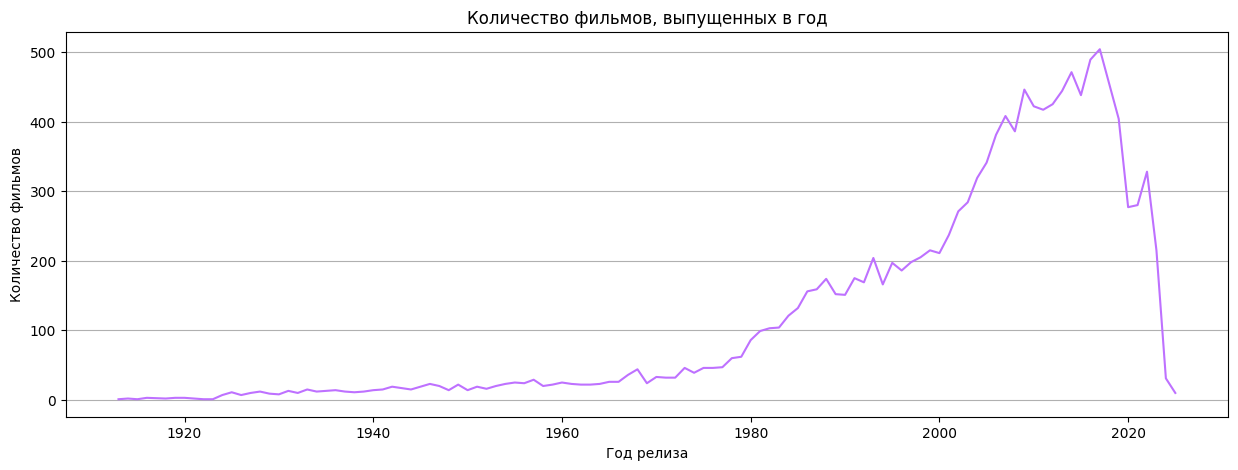

In [74]:
plt.figure(figsize=(15, 5))

plt.plot(films_year['year'],
         films_year['count'],
          color='#be71ff')

plt.title('Количество фильмов, выпущенных в год')
plt.xlabel('Год релиза')
plt.ylabel('Количество фильмов')
plt.grid(axis='y')
plt.show()

продолжение следует...